In [1]:
import pandas as pd
import altair as alt
import numpy as np
import seaborn as sns
import copy
import ast
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import sys
import os

sys.path.insert(0, '../../')

from sklearn.preprocessing import LabelEncoder, StandardScaler
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, VotingClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn import linear_model
from sklearn.metrics import confusion_matrix, recall_score, classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB

from library.notebook_api.data_loader import CombinedDataLoader, ModelDataLoader

alt.data_transformers.enable("vegafusion")
alt.renderers.enable('default')

RendererRegistry.enable('default')

## Load Data 

In [2]:
#load data using ModelDataLoader
full_model_data = ModelDataLoader('003')
data_df = full_model_data.df

In [3]:
data_df

,level_0,index,track_id,dataset,audio_path,label,fma_genre_top,fma_genres,fma_genres_all,file_available,...,zero_crossing_rate_mean,rms_mean,chroma_stft_mean,mfccs_mean,onset,tempo,contrast,tonnetz,mfccs_min,mfccs_max
0,0,0,000002,fma,/project_data_source/free_music_archive/fma_sm...,hiphop,Hip-Hop,[21],[21],1.0,...,0.098364,0.141225,0.424169,-1.742610,1.403928,166.708664,21.300203,0.022087,-505.499176,196.868652
1,1,2,000005,fma,/project_data_source/free_music_archive/fma_sm...,hiphop,Hip-Hop,[21],[21],1.0,...,0.059334,0.145243,0.475249,1.318397,1.384270,99.384018,21.096722,0.005648,-528.116272,209.443054
2,2,3,000010,fma,/project_data_source/free_music_archive/fma_sm...,pop,Pop,[10],[10],1.0,...,0.080989,0.186656,0.430406,2.244156,1.123551,112.347145,20.852177,-0.033316,-537.197205,229.155151
3,3,15,000140,fma,/project_data_source/free_music_archive/fma_sm...,folk,Folk,[17],[17],1.0,...,0.027256,0.068459,0.450882,-3.624865,1.135973,107.666016,21.727451,0.012266,-592.895813,199.950806
4,4,16,000141,fma,/project_data_source/free_music_archive/fma_sm...,folk,Folk,[17],[17],1.0,...,0.034120,0.100852,0.341356,-4.471582,0.881413,120.185318,23.654802,-0.003315,-536.546936,222.208649
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49754,395,49593,155315,fma,/project_data_source/free_music_archive/fma_la...,rock,Rock,[25],[25],1.0,...,0.032357,0.136684,0.525699,2.354369,1.015966,100.446426,21.076494,0.026837,-481.190033,235.711487
49755,396,49594,155316,fma,/project_data_source/free_music_archive/fma_la...,rock,Rock,[25],[25],1.0,...,0.026704,0.143535,0.443451,3.344367,1.024267,89.285713,21.251328,0.056219,-281.556030,235.779968
49756,397,49595,155317,fma,/project_data_source/free_music_archive/fma_la...,rock,Rock,[25],[25],1.0,...,0.038817,0.113076,0.638051,3.844987,0.966649,117.187500,20.655001,-0.004262,-248.138168,220.233063
49757,398,49596,155318,fma,/project_data_source/free_music_archive/fma_la...,rock,Rock,[25],[25],1.0,...,0.040220,0.105109,0.588148,2.824294,1.051786,95.338982,20.832283,0.012935,-303.344910,233.896667


### Select in scope genres and check how well classes are balanced 

In [4]:
#filter on six genres in scope
in_scope_labels = [
    'rock', 'electronic', 'hiphop', 'classical', 'jazz', 'country'
]
data_df = data_df[data_df['label'].isin(in_scope_labels)]

In [5]:
#visualize class imbalance (% of data by genre in scope)
class_dis = pd.DataFrame(data_df['label'].value_counts(normalize=True) *
                         100).reset_index()

alt.Chart(class_dis).mark_bar().encode(
    x=alt.X('label:Q', title='% of data'),
    y=alt.Y('index:N', sort='-x', title=None),
    color=alt.Color('label:Q',
                    legend=None)).properties(title='Class Imbalance')

alt.Chart(...)

## Train - Test Split 

In [6]:
#split data
y = data_df['label']
x = data_df[[
    'spectral_centroids_mean', 'spectral_centroids_delta_mean',
    'spectral_centroids_accelerate_mean', 'spectral_bandwidth_mean',
    'spectral_rolloff_mean', 'zero_crossing_rate_mean', 'rms_mean',
    'chroma_stft_mean', 'mfccs_mean', 'tempo', 'onset', 'contrast', 'tonnetz',
    'mfccs_min', 'mfccs_max'
]]

X_train, X_test, y_train, y_test = train_test_split(x,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

#train_df includes features (X_train) and labels (y_train)
train_df = pd.concat([X_train, y_train], axis=1)

#return y_test index array
y_test_index = y_test.index.values
y_test_index

array([20322,  9763,  8651, ..., 18718, 29281, 41691])

## SMOTE for class imbalance 

In [7]:
#use smote on training data for data augmentation
smote = SMOTE(random_state=42)

#check length of X train and y train
print(len(X_train))
print(len(y_train))

x_smote, y_smote = smote.fit_resample(X_train, y_train)

#check value counts for augmented data
y_smote.value_counts()
print(len(x_smote))

23480
23480
68226


# Classificaiton 

## Original dataset with all features 

In [8]:
#original dataset split (without smote augmentation)
X_train_og, X_test_og, y_train_og, y_test_og = train_test_split(
    x, y, test_size=0.2, random_state=42, stratify=y)

#train random forest
RandomForest = RandomForestClassifier(random_state=42)
RandomForest.fit(X_train_og, y_train_og)

#predict labels
y_pred_og = RandomForest.predict(X_test_og)

In [9]:
#display classification by genre, including overall accuracy score 
print(classification_report(y_test_og, y_pred_og))

              precision    recall  f1-score   support

   classical       0.73      0.82      0.77       263
     country       0.67      0.07      0.12        59
  electronic       0.69      0.71      0.70      1830
      hiphop       0.70      0.50      0.58       726
        jazz       0.75      0.07      0.12       134
        rock       0.80      0.88      0.84      2858

    accuracy                           0.75      5870
   macro avg       0.72      0.51      0.52      5870
weighted avg       0.75      0.75      0.74      5870



## Full dataset/ smote for imbalanced classes

### Random Forest

In [10]:
#train random forest (data with smote augmentation)
RandomForest = RandomForestClassifier(random_state=42)
RandomForest.fit(x_smote, y_smote)

#predict labels
y_pred_smote = RandomForest.predict(X_test)

In [11]:
#display classification by genre, including overall accuracy score 
classification_report_rf = pd.DataFrame(
    classification_report(y_test, y_pred_smote, output_dict=True)).T
classification_report_rf

,precision,recall,f1-score,support
classical,0.628571,0.839695,0.718954,262.000000
country,0.246377,0.314815,0.276423,54.000000
electronic,0.712029,0.647156,0.678045,1811.000000
hiphop,0.605691,0.657353,0.630465,680.000000
jazz,0.193548,0.293706,0.233333,143.000000
rock,0.845965,0.825685,0.835702,2920.000000
accuracy,0.734072,0.734072,0.734072,0.734072
macro avg,0.538697,0.596402,0.562154,5870.000000
weighted avg,0.745697,0.734072,0.738256,5870.000000


### Decision Tree

In [12]:
#train decision tree classifier 
clf = DecisionTreeClassifier()
clf = clf.fit(x_smote, y_smote)

#predict with decision tree classifier 
y_pred_smote_dt = clf.predict(X_test)

In [13]:
#get classification report for decision tree classifier 
classification_report_dt = pd.DataFrame(
    classification_report(y_test, y_pred_smote_dt, output_dict=True)).T

classification_report_dt

,precision,recall,f1-score,support
classical,0.551929,0.709924,0.621035,262.000000
country,0.068293,0.259259,0.108108,54.000000
electronic,0.580975,0.532855,0.555876,1811.000000
hiphop,0.422551,0.545588,0.476252,680.000000
jazz,0.102778,0.258741,0.147117,143.000000
rock,0.804035,0.668836,0.730230,2920.000000
accuracy,0.600681,0.600681,0.600681,0.600681
macro avg,0.421760,0.495867,0.439770,5870.000000
weighted avg,0.655920,0.600681,0.622215,5870.000000


In [14]:
#get recall, precision, and accuracy scores for decision tree classifier 
dt_recall = classification_report_dt['recall']
dt_precision = classification_report_dt['precision']
dt_accuracy = round(accuracy_score(y_test, y_pred_smote_dt), 2)
dt_accuracy

0.6

### Regression

In [15]:
#train linear regression model
lm = linear_model.LogisticRegression(multi_class='ovr', solver='liblinear')
lm.fit(x_smote, y_smote)

#create prediction with linear regression model 
y_pred_smote_lm = lm.predict(X_test)

In [16]:
#get classification report by genre for linear regression 
classification_report_reg = pd.DataFrame(
    classification_report(y_test, y_pred_smote_lm, output_dict=True)).T
classification_report_reg

,precision,recall,f1-score,support
classical,0.416357,0.854962,0.560000,262.000000
country,0.039557,0.462963,0.072886,54.000000
electronic,0.545748,0.279956,0.370073,1811.000000
hiphop,0.371841,0.605882,0.460850,680.000000
jazz,0.077778,0.146853,0.101695,143.000000
rock,0.785207,0.643493,0.707322,2920.000000
accuracy,0.522658,0.522658,0.522658,0.522658
macro avg,0.372748,0.499018,0.378804,5870.000000
weighted avg,0.622888,0.522658,0.547557,5870.000000


In [17]:
#get regression recall, precision, and accuracy scores
reg_recall = classification_report_reg['recall']
reg_precision = classification_report_reg['precision']
reg_accuracy = round(accuracy_score(y_test, y_pred_smote_lm), 2)
reg_accuracy

0.52

### SVM

In [ ]:
#train SVC model and predict 
svm = svm.SVC()

svm.fit(x_smote, y_smote)
y_pred_svm = svm.predict(X_test)

In [ ]:
#get classification report 
classification_report_svm = pd.DataFrame(
    classification_report(y_test, y_pred_svm, output_dict=True)).T
classification_report_svm

In [ ]:
#extract recall, precision, and accuracy scores
svm_recall = classification_report_svm['recall']
svm_precision = classification_report_svm['precision']
svm_accuracy = round(accuracy_score(y_test, y_pred_svm), 2)
svm_accuracy

### NB

In [21]:
X_train_NB = copy.deepcopy(X_train) #copy of training dataset 

#convert to absoulute values variables that have negative values 
X_train_NB['mfccs_min_abs'] = abs(X_train_NB['mfccs_min']) 
X_train_NB['mfccs_mean_abs'] = abs(X_train_NB['mfccs_mean'])
X_train_NB['tonnetz_abs'] = abs(X_train_NB['tonnetz'])
X_train_NB['spectral_centroids_delta_mean_abs'] = abs(
    X_train_NB['spectral_centroids_delta_mean'])
X_train_NB['spectral_centroids_accelerate_mean_abs'] = abs(
    X_train_NB['spectral_centroids_accelerate_mean'])

#X train with absolute values 
X_train_abs = X_train_NB[[
    'spectral_centroids_mean', 'spectral_centroids_delta_mean_abs',
    'spectral_centroids_accelerate_mean_abs', 'spectral_bandwidth_mean',
    'spectral_rolloff_mean', 'zero_crossing_rate_mean', 'rms_mean',
    'chroma_stft_mean', 'mfccs_mean_abs', 'tempo', 'onset', 'contrast',
    'tonnetz_abs', 'mfccs_min_abs', 'mfccs_max'
]]

X_test_NB = copy.deepcopy(X_test)#deep copy of the test data

#convert to absolute values variables for X_test 
X_test_NB['mfccs_min_abs'] = abs(X_test_NB['mfccs_min'])
X_test_NB['mfccs_mean_abs'] = abs(X_test_NB['mfccs_mean'])
X_test_NB['tonnetz_abs'] = abs(X_test_NB['tonnetz'])
X_test_NB['spectral_centroids_delta_mean_abs'] = abs(
    X_test_NB['spectral_centroids_delta_mean'])
X_test_NB['spectral_centroids_accelerate_mean_abs'] = abs(
    X_test_NB['spectral_centroids_accelerate_mean'])

#X test with absolute values 
X_test_abs = X_test_NB[[
    'spectral_centroids_mean', 'spectral_centroids_delta_mean_abs',
    'spectral_centroids_accelerate_mean_abs', 'spectral_bandwidth_mean',
    'spectral_rolloff_mean', 'zero_crossing_rate_mean', 'rms_mean',
    'chroma_stft_mean', 'mfccs_mean_abs', 'tempo', 'onset', 'contrast',
    'tonnetz_abs', 'mfccs_min_abs', 'mfccs_max'
]]

In [22]:
#fit NB model and predict 
model = MultinomialNB()
model.fit(X_train_abs, (y_train))
y_pred = model.predict(X_test_abs)

#calculate accuracy for NB model and produce classification report
nb_accuracy = round(accuracy_score(y_test, y_pred), 2)
classification_report_nb = pd.DataFrame(
    classification_report(y_test, y_pred, output_dict=True)).T
classification_report_nb

,precision,recall,f1-score,support
classical,0.244804,0.809160,0.375887,262.000000
country,0.055901,0.166667,0.083721,54.000000
electronic,0.428368,0.331861,0.373989,1811.000000
hiphop,0.197183,0.350000,0.252252,680.000000
jazz,0.032717,0.321678,0.059393,143.000000
rock,0.715840,0.202740,0.315986,2920.000000
accuracy,0.289267,0.289267,0.289267,0.289267
macro avg,0.279135,0.363684,0.243538,5870.000000
weighted avg,0.523330,0.289267,0.320784,5870.000000


In [23]:
#get recall and precision scores for NB classifier 
nb_recall = classification_report_nb['recall']
nb_precision = classification_report_nb['precision']

## Tune parameters for Random Forest

In [24]:
#define parameters for tuning 
n_estimators = [int(x) for x in np.linspace(start=100, stop=2000, num=10)]

max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {
    'n_estimators': n_estimators,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap
}

random_grid

{'n_estimators': [100, 311, 522, 733, 944, 1155, 1366, 1577, 1788, 2000],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4],
 'bootstrap': [True, False]}

In [25]:
#initialize randomforest classifier and fit the model 
rf = RandomForestClassifier()

rf_random = RandomizedSearchCV(estimator=rf,
                               param_distributions=random_grid,
                               n_iter=100,
                               cv=3,
                               verbose=2,
                               random_state=42,
                               n_jobs=-1)
rf_random.fit(X_test, y_test)

rf_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'n_estimators': 1366,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_depth': 20,
 'bootstrap': True}

In [26]:
#random forest with best parameters 
RandomForest_2 = RandomForestClassifier(random_state=42,
                                        n_estimators=1577,
                                        min_samples_split=2,
                                        min_samples_leaf=1,
                                        max_depth=50,
                                        bootstrap=True)

RandomForest_2.fit(x_smote, y_smote)

#predict using random forest with best params
y_pred_smote = RandomForest_2.predict(X_test)

[CV] END bootstrap=True, max_depth=80, min_samples_leaf=2, min_samples_split=2, n_estimators=1788; total time=  19.7s
[CV] END bootstrap=False, max_depth=80, min_samples_leaf=1, min_samples_split=2, n_estimators=1577; total time=  28.1s
[CV] END bootstrap=True, max_depth=70, min_samples_leaf=1, min_samples_split=10, n_estimators=1577; total time=  16.5s
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   1.7s
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=944; total time=  15.3s
[CV] END bootstrap=True, max_depth=40, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.9s
[CV] END bootstrap=False, max_depth=60, min_samples_leaf=2, min_samples_split=10, n_estimators=1366; total time=  22.6s
[CV] END bootstrap=False, max_depth=80, min_samples_leaf=2, min_samples_split=2, n_estimators=1577; total time=  27.1s
[CV] END bootstrap=False, max_depth=50, min_sampl

[CV] END bootstrap=False, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=2000; total time=  37.2s
[CV] END bootstrap=True, max_depth=80, min_samples_leaf=2, min_samples_split=5, n_estimators=944; total time=  10.2s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=944; total time=  10.5s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=2000; total time=  15.8s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=4, min_samples_split=2, n_estimators=1577; total time=  15.9s
[CV] END bootstrap=False, max_depth=110, min_samples_leaf=1, min_samples_split=10, n_estimators=522; total time=   8.8s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=311; total time=   3.2s
[CV] END bootstrap=False, max_depth=80, min_samples_leaf=1, min_samples_split=5, n_estimators=1366; total time=  24.4s
[CV] END bootstrap=True, max_depth=50, min_samp

[CV] END bootstrap=False, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=2000; total time=  35.9s
[CV] END bootstrap=True, max_depth=80, min_samples_leaf=2, min_samples_split=5, n_estimators=944; total time=  10.3s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=944; total time=  10.6s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=2000; total time=  15.8s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=4, min_samples_split=2, n_estimators=1577; total time=  15.9s
[CV] END bootstrap=True, max_depth=110, min_samples_leaf=4, min_samples_split=2, n_estimators=1155; total time=  11.4s
[CV] END bootstrap=True, max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=944; total time=  10.4s
[CV] END bootstrap=False, max_depth=70, min_samples_leaf=2, min_samples_split=5, n_estimators=1577; total time=  27.7s
[CV] END bootstrap=False, max_depth=40, min_sampl

[CV] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=733; total time=   8.3s
[CV] END bootstrap=True, max_depth=90, min_samples_leaf=4, min_samples_split=2, n_estimators=1788; total time=  18.7s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=1577; total time=  24.1s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=1155; total time=  11.5s
[CV] END bootstrap=False, max_depth=90, min_samples_leaf=2, min_samples_split=5, n_estimators=1155; total time=  19.2s
[CV] END bootstrap=True, max_depth=40, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.2s
[CV] END bootstrap=True, max_depth=30, min_samples_leaf=4, min_samples_split=5, n_estimators=311; total time=   3.0s
[CV] END bootstrap=False, max_depth=40, min_samples

In [27]:
#get classification report by genre for random forest with best params
print(classification_report(y_test, y_pred_smote))

              precision    recall  f1-score   support

   classical       0.62      0.83      0.71       262
     country       0.29      0.33      0.31        54
  electronic       0.72      0.64      0.68      1811
      hiphop       0.62      0.67      0.64       680
        jazz       0.21      0.31      0.25       143
        rock       0.85      0.83      0.84      2920

    accuracy                           0.74      5870
   macro avg       0.55      0.60      0.57      5870
weighted avg       0.75      0.74      0.74      5870



In [28]:
#get recall, precision, and accuracy scores for random forest with best parameters 
rf_recall = classification_report_rf['recall']
rf_precision = classification_report_rf['precision']
rf_accuracy = round(accuracy_score(y_test, y_pred_smote), 2)
rf_accuracy

0.74

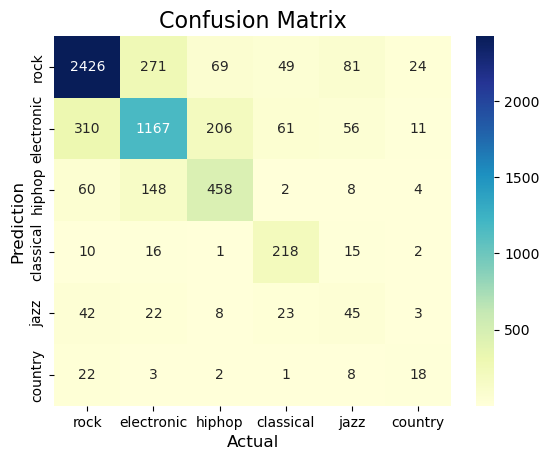

In [32]:
#return confusion matrix for y_test and y_predicted using random forest (smote for class imbalance)
cm = confusion_matrix(y_test, y_pred_smote, labels=in_scope_labels)

#plot confusion matrix by genre
sns.heatmap(cm,
            annot=True,
            fmt='d',
            cmap='YlGnBu',
            xticklabels=in_scope_labels,
            yticklabels=in_scope_labels)
plt.ylabel('Prediction', fontsize=12)
plt.xlabel('Actual', fontsize=12)
plt.title('Confusion Matrix', fontsize=16)
plt.show()

## XGBoost Parameter Tunning 

In [33]:
#Encode labels into numerical values
print(in_scope_labels)
genre_mapping = {
    'rock': 1,
    'electronic': 2,
    'hiphop': 3,
    'classical': 4,
    'jazz': 5,
    'country': 0
}

reverse_mapping = {v: k for k, v in genre_mapping.items()}

# Convert genres to numeric values
y_encoded = np.vectorize(genre_mapping.get)(y)
# Check the label encoding
y_encoded

['rock', 'electronic', 'hiphop', 'classical', 'jazz', 'country']


array([3, 3, 1, ..., 1, 1, 1])

In [34]:
#Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x,
                                                    y_encoded,
                                                    test_size=0.2,
                                                    random_state=42)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")


#Apply SMOTE to balance the training data
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# XGBoost parameter grid
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0]
}

#Perform Grid Search on XGBoost
xgb_model = XGBClassifier(eval_metric='mlogloss', random_state=42)
xgb_grid_search = GridSearchCV(estimator=xgb_model,
                               param_grid=xgb_param_grid,
                               cv=3,
                               scoring='accuracy',
                               n_jobs=-1,
                               verbose=1)
xgb_grid_search.fit(X_train_balanced, y_train_balanced)

# Get the best XGBoost model and parameters
best_xgb = xgb_grid_search.best_estimator_
print("Best XGBoost Parameters:", xgb_grid_search.best_params_)

# XGBoost evaluation
y_pred_xgb = best_xgb.predict(X_test)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print("\nBest XGBoost Accuracy:", accuracy_xgb)
print("Classification Report for XGBoost:\n",
      classification_report(y_test, y_pred_xgb))

Training set size: (23480, 15)
Test set size: (5870, 15)
Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best XGBoost Parameters: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.6}

Best XGBoost Accuracy: 0.7546848381601363
Classification Report for XGBoost:
               precision    recall  f1-score   support

           0       0.31      0.28      0.29        54
           1       0.84      0.85      0.84      2920
           2       0.72      0.67      0.70      1811
           3       0.61      0.68      0.65       680
           4       0.72      0.79      0.76       262
           5       0.32      0.25      0.28       143

    accuracy                           0.75      5870
   macro avg       0.59      0.59      0.59      5870
weighted avg       0.75      0.75      0.75      5870



In [35]:
#return classifcation report by genre 
classification_report_gb = pd.DataFrame(
    classification_report(y_test,
                          y_pred_xgb,
                          output_dict=True)).T
#extract precision score 
gb_precision = classification_report_gb['precision']
#extract recall score 
gb_recall = classification_report_gb['recall']
#extract accuracy score 
gb_accuracy = round(accuracy_score(y_test, y_pred_xgb), 2)


In [36]:
#get prediction probabilities and output as a df with genre labels 
probab_df = pd.DataFrame(best_xgb.predict_proba(X_test))
probab_df.columns = [
    'country', 'rock', 'electronic', 'hiphop', 'classical', 'jazz'
]

In [37]:
# predicted probabilities; y_true and y_predicted
probab_df['y_pred_num'] = y_pred_xgb
probab_df['y_true_num'] = y_test

#add index 
probab_df['index'] = y_test_index

#decode from numeric to categorical values
probab_df['y_pred'] = probab_df['y_pred_num'].replace(reverse_mapping)
probab_df['y_true'] = probab_df['y_true_num'].replace(reverse_mapping)

In [38]:
#add audio path to dataframe
filter_on_index = data_df.loc[y_test_index]
audio_path = filter_on_index[['audio_path']]
audio_path.reset_index(inplace=True)
probab_df['audio_path'] = audio_path['audio_path']
probab_df

,country,rock,electronic,hiphop,classical,jazz,y_pred_num,y_true_num,index,y_pred,y_true,audio_path
0,1.953017e-04,0.059705,0.814714,0.123469,0.000015,1.901351e-03,2,3,20322,electronic,hiphop,/project_data_source/free_music_archive/fma_me...
1,2.046359e-05,0.994463,0.005311,0.000102,0.000028,7.604518e-05,1,1,9763,rock,rock,/project_data_source/free_music_archive/fma_me...
2,2.019983e-06,0.991853,0.000026,0.008110,0.000007,1.830517e-06,1,1,8651,rock,rock,/project_data_source/gtzan_dataset/Data/genres...
3,1.209892e-06,0.068194,0.352214,0.579251,0.000099,2.411309e-04,3,3,22224,hiphop,hiphop,/project_data_source/free_music_archive/fma_me...
4,2.762263e-05,0.894631,0.076174,0.005677,0.000138,2.335308e-02,1,1,42476,rock,rock,/project_data_source/free_music_archive/fma_la...
...,...,...,...,...,...,...,...,...,...,...,...,...
5865,5.893245e-04,0.996987,0.001966,0.000097,0.000006,3.553776e-04,1,1,41634,rock,rock,/project_data_source/free_music_archive/fma_la...
5866,8.612594e-02,0.886220,0.013193,0.012899,0.000149,1.412857e-03,1,1,41643,rock,rock,/project_data_source/free_music_archive/fma_la...
5867,8.605118e-08,0.002854,0.996754,0.000390,0.000002,3.789279e-07,2,2,18718,electronic,electronic,/project_data_source/free_music_archive/fma_me...
5868,6.287343e-06,0.003967,0.035678,0.960172,0.000045,1.320147e-04,3,3,29281,hiphop,hiphop,/project_data_source/free_music_archive/fma_la...


In [39]:
#output probability dataframe to csv 
probab_df.to_csv('predicted_prob.csv', index=False)

### Confusion Matrix 

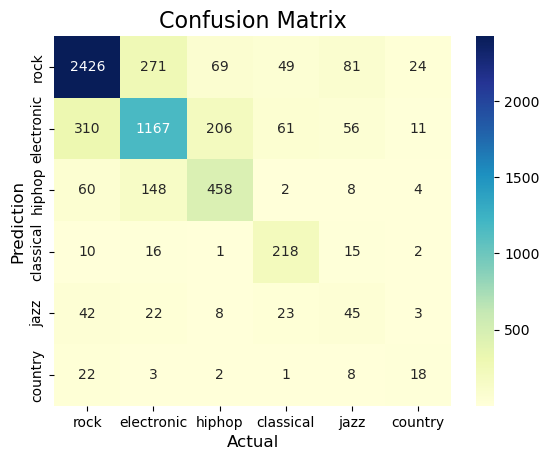

In [40]:
#return confusion matrix based on y test and prediction using xgboost 
cm_xgb = confusion_matrix(y_test, y_pred_xgb)

#plot confusion matrix 
sns.heatmap(cm,
            annot=True,
            fmt='d',
            cmap='YlGnBu',
            xticklabels=in_scope_labels,
            yticklabels=in_scope_labels)
plt.ylabel('Prediction', fontsize=12)
plt.xlabel('Actual', fontsize=12)
plt.title('Confusion Matrix', fontsize=16)
plt.show()

## Ensemble Model (XGBoost and RF) 

In [41]:
#Define models with the best parameters
best_rf = RandomForestClassifier(random_state=42,
                                 n_estimators=1577,
                                 min_samples_split=2,
                                 min_samples_leaf=1,
                                 max_depth=50,
                                 bootstrap=True)

best_xgb = XGBClassifier(n_estimators=300,
                         max_depth=7,
                         learning_rate=0.2,
                         subsample=0.8,
                         eval_metric='mlogloss',
                         random_state=42)

# Create the weighted soft voting ensemble
ensemble_model_weighted = VotingClassifier(
    estimators=[
        ('rf', best_rf),  # Random Forest
        ('xgb', best_xgb)  # XGBoost
    ],
    voting='soft',
    weights=[2, 3]  # Favor XGBoost due to higher performance
)

# Train the ensemble model
ensemble_model_weighted.fit(X_train_balanced, y_train_balanced)

# Make predictions on the test data
y_pred_weighted = ensemble_model_weighted.predict(X_test)

#Evaluate the model's performance
accuracy_weighted = accuracy_score(y_test, y_pred_weighted)
classification_report_weighted = classification_report(
    y_test, y_pred_weighted)

# Output the results
print("Accuracy with Optimized Soft Voting Ensemble (RF + XGBoost):",
      accuracy_weighted)
print("Classification Report:\n", classification_report_weighted)

Accuracy with Optimized Soft Voting Ensemble (RF + XGBoost): 0.7599659284497444
Classification Report:
               precision    recall  f1-score   support

           0       0.36      0.31      0.34        54
           1       0.84      0.85      0.85      2920
           2       0.73      0.68      0.70      1811
           3       0.62      0.69      0.65       680
           4       0.70      0.80      0.75       262
           5       0.35      0.29      0.32       143

    accuracy                           0.76      5870
   macro avg       0.60      0.60      0.60      5870
weighted avg       0.76      0.76      0.76      5870



In [42]:
#get classification report, precision, recall, accuracy scores for ensemble model 
classification_report_ens = pd.DataFrame(
    classification_report(y_test,
                          y_pred_weighted,
                          output_dict=True)).T

ens_precision = classification_report_ens['precision']
ens_recall = classification_report_ens['recall']
ens_accuracy = round(accuracy_score(y_test, y_pred_weighted), 2)
classification_report_ens

,precision,recall,f1-score,support
0,0.361702,0.314815,0.336634,54.000000
1,0.842799,0.853767,0.848248,2920.000000
2,0.725132,0.680287,0.701994,1811.000000
3,0.623169,0.688235,0.654088,680.000000
4,0.702341,0.801527,0.748663,262.000000
5,0.353448,0.286713,0.316602,143.000000
accuracy,0.759966,0.759966,0.759966,0.759966
macro avg,0.601432,0.604224,0.601038,5870.000000
weighted avg,0.758438,0.759966,0.758531,5870.000000


## Summary Recall Chart 

In [43]:
#create summary dataframe for recall score for each model by genre 
summary_recall = pd.concat([
    rf_recall, dt_recall, gb_recall, svm_recall, nb_recall, reg_recall,
    ens_recall
],
                           axis=1)
model_names = [
    'Random Forest', 'Decision Tree', 'XGBoost', 'SVM',
    'Multinomial NaiveBayes', 'Logistic Regression', 'Ensamble XGB + RF'
]

summary_recall.columns = model_names

summary_recall = summary_recall.T
summary_recall.reset_index(inplace=True)
summary_recall

,index,classical,country,electronic,hiphop,jazz,rock,accuracy,macro avg,weighted avg,0,1,2,3,4,5
0,Random Forest,0.839695,0.314815,0.647156,0.657353,0.293706,0.825685,0.734072,0.596402,0.734072,NaN,NaN,NaN,NaN,NaN,NaN
1,Decision Tree,0.709924,0.277778,0.520707,0.560294,0.279720,0.672260,0.601022,0.503447,0.601022,NaN,NaN,NaN,NaN,NaN,NaN
2,XGBoost,NaN,NaN,NaN,NaN,NaN,NaN,0.754685,0.587735,0.754685,0.277778,0.854110,0.670348,0.682353,0.790076,0.251748
3,SVM,0.816794,0.481481,0.313087,0.530882,0.258741,0.351370,0.380068,0.458726,0.380068,NaN,NaN,NaN,NaN,NaN,NaN
4,Multinomial NaiveBayes,0.809160,0.166667,0.331861,0.350000,0.321678,0.202740,0.289267,0.363684,0.289267,NaN,NaN,NaN,NaN,NaN,NaN
5,Logistic Regression,0.854962,0.462963,0.279956,0.605882,0.146853,0.643493,0.522658,0.499018,0.522658,NaN,NaN,NaN,NaN,NaN,NaN
6,Ensamble XGB + RF,NaN,NaN,NaN,NaN,NaN,NaN,0.759966,0.604224,0.759966,0.314815,0.853767,0.680287,0.688235,0.801527,0.286713


In [44]:
#create chart to show score by genre 
alt.Chart(summary_recall).mark_bar().encode(
    x=alt.X('amount:Q', title=None),
    y=alt.Y('type:N', title=None),
    color=alt.Color('amount:Q', legend=None),
    column=alt.Column('index',
                      title=None)).transform_fold(as_=['type', 'amount'],
                                                  fold=in_scope_labels).properties(
                                                      width=100,
                                                      title='Recall by Model')

alt.Chart(...)

## Summary Precision Chart 

In [45]:
#summary dataframe for precision scores across models 
summary_precision = pd.concat([
    rf_precision, dt_precision, gb_precision, svm_precision, nb_precision,
    reg_precision, ens_precision
],
                              axis=1)

model_names = [
    'Random Forest', 'Decision Tree', 'XGBoost', 'SVM',
    'Multinomial NaiveBayes', 'Logistic Regression', 'Ensamble XGB + RF'
]

summary_precision.columns = model_names

summary_precision = summary_precision.T
summary_precision.reset_index(inplace=True)
summary_precision

,index,classical,country,electronic,hiphop,jazz,rock,accuracy,macro avg,weighted avg,0,1,2,3,4,5
0,Random Forest,0.628571,0.246377,0.712029,0.605691,0.193548,0.845965,0.734072,0.538697,0.745697,NaN,NaN,NaN,NaN,NaN,NaN
1,Decision Tree,0.563636,0.077720,0.575702,0.427609,0.108992,0.800898,0.601022,0.425760,0.654080,NaN,NaN,NaN,NaN,NaN,NaN
2,XGBoost,NaN,NaN,NaN,NaN,NaN,NaN,0.754685,0.588423,0.752243,0.312500,0.835231,0.721760,0.612946,0.723776,0.324324
3,SVM,0.394834,0.043046,0.667059,0.201676,0.050477,0.759437,0.380068,0.352755,0.626189,NaN,NaN,NaN,NaN,NaN,NaN
4,Multinomial NaiveBayes,0.244804,0.055901,0.428368,0.197183,0.032717,0.715840,0.289267,0.279135,0.523330,NaN,NaN,NaN,NaN,NaN,NaN
5,Logistic Regression,0.416357,0.039557,0.545748,0.371841,0.077778,0.785207,0.522658,0.372748,0.622888,NaN,NaN,NaN,NaN,NaN,NaN
6,Ensamble XGB + RF,NaN,NaN,NaN,NaN,NaN,NaN,0.759966,0.601432,0.758438,0.361702,0.842799,0.725132,0.623169,0.702341,0.353448


In [46]:
#bar chart for precision scores by model 
alt.Chart(summary_precision).mark_bar().encode(
    x=alt.X('amount:Q', title=None),
    y=alt.Y('type:N', title=None),
    color=alt.Color('amount:Q', legend=None, scale=alt.Scale(scheme='greens')),
    column=alt.Column('index', title=None)).transform_fold(
        as_=['type',
             'amount'], fold=in_scope_labels).properties(width=100,
                                                title='Precision by Model')

alt.Chart(...)

## Summary Accuracy Scores 

In [47]:
#combine accuracy scores from all models run
accuracy_scores = [
    rf_accuracy, dt_accuracy, gb_accuracy, svm_accuracy, nb_accuracy,
    reg_accuracy, ens_accuracy
]
model_names = [
    'Random Forest', 'Decision Tree', 'XGBoost', 'SVM',
    'Multinomial NaiveBayes', 'Logistic Regression', 'Ensamble XGB + RF'
]

accuracy_scores_summary = pd.DataFrame({
    'accuracy_scores': accuracy_scores,
    'model_names': model_names
})

accuracy_scores_summary

,accuracy_scores,model_names
0,0.74,Random Forest
1,0.60,Decision Tree
2,0.75,XGBoost
3,0.38,SVM
4,0.29,Multinomial NaiveBayes
5,0.52,Logistic Regression
6,0.76,Ensamble XGB + RF


In [48]:
#create a chart for the highest accuracy score by model 
base = alt.Chart(accuracy_scores_summary).encode(
    y=alt.Y('model_names:N', title=None, sort='-x'),
    x=alt.X('accuracy_scores:Q', title=None, axis=None),
    color=alt.Color('accuracy_scores:Q',
                    legend=None,
                    scale=alt.Scale(scheme='oranges')),
    text=alt.Text('accuracy_scores:Q')).properties(
        width=400, height=200, title='Highest Accuracy Score by Model')

(base.mark_bar(size=20) + base.mark_text(align='left', dx=1)).configure_view(
    strokeWidth=0).configure_axis(grid=False, domain=False)

alt.LayerChart(...)